# Определение наиболее выгодного региона нефтедобычи

Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину. 
Шаги для выбора локации обычно такие:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль, а также проанализировать возможную прибыль и риски техникой Bootstrap.

**Дано:** три датасета с данными геологоразведки трёх регионов, в которых

- `'id'` — уникальный идентификатор скважины
- `'f0', 'f1', 'f2'` — три признака точек (неважно, что они означают, но сами признаки значимы)
- `'product'` — объём запасов в скважине (тыс. баррелей)

**Условия задачи:**

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
from io import BytesIO
import requests
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from numpy.random import RandomState
from scipy import stats as st
import numpy as np

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
try:
    df_0 = pd.read_csv('/datasets/geo_data_0.csv')
    df_1 = pd.read_csv('/datasets/geo_data_1.csv')
    df_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    spreadsheet_id_0 = '1w0zqTKs4YwsHgxe7R1-COJ87avQmpHIF7DNz9BqThCs'
    file_name_0 = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id_0)
    r_0 = requests.get(file_name_0)

    spreadsheet_id_1 = '1ATIN98bO0iysxFamxEWSY6QhKfFp2gVcs5IOS1F0BVY'
    file_name_1 = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id_1)
    r_1 = requests.get(file_name_1)

    spreadsheet_id_2 = '1YwtOZ8X4XOsWK0RcijccIhgeqjZM2hn9TtdT9ODpD8g'
    file_name_2 = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id_2)
    r_2 = requests.get(file_name_2)


    df_0 = pd.read_csv(BytesIO(r_0.content))
    df_1 = pd.read_csv(BytesIO(r_1.content))
    df_2 = pd.read_csv(BytesIO(r_2.content))

In [3]:
print(df_0.head())
print(df_1.head())
print(df_2.head())

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305
      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746


Посмотрим распределния признаков и целевых значений

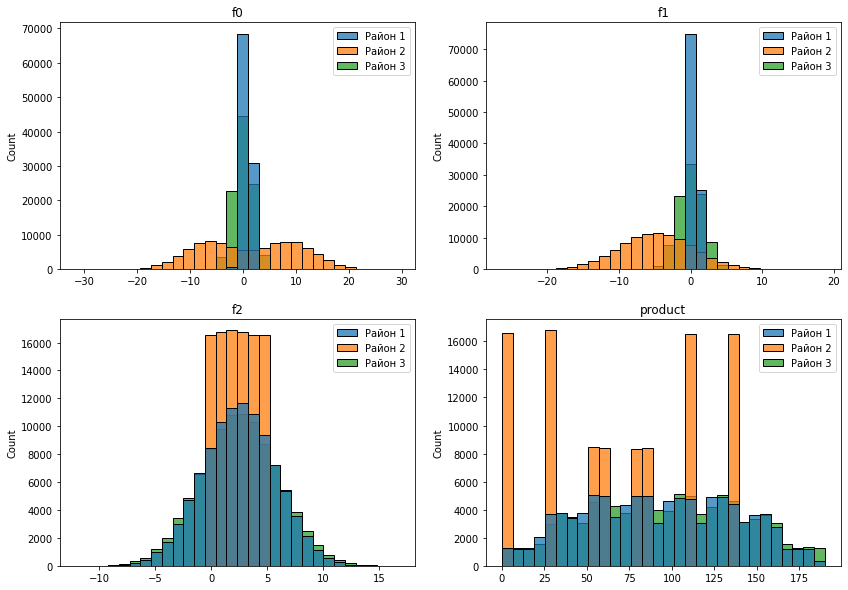

In [4]:
plt.figure(figsize=(14, 10))
for a, b in enumerate(['f0', 'f1', 'f2', 'product']):
    plt.subplot(2, 2, a+1)
    sns.histplot(pd.DataFrame({'Район 1': df_0[b], 'Район 2': df_1[b], 'Район 3': df_2[b]}), bins=30)
    plt.title(b)

Проверим поочередно все данные, сведя анализ данных в функцию.

In [5]:
def info(df):
    print(df.head())
    print('--------------------------------------------------------------')
    print(df.info())
    print('--------------------------------------------------------------')
    print('Количество дубликатов в id:', df_0['id'].duplicated().sum())
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    df[['f0', 'f1', 'f2']].boxplot(figsize=(15,10))
    plt.title('Ящик с усами')
    
    plt.subplot(1, 2, 2)
    sns.heatmap(df[['f0', 'f1', 'f2']].corr(), annot=True)
    plt.title('Мультиколлинеарность по коэффициенту Пирсона');
    return

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
--------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
--------------------------------------------------------------
Количество дубликатов в id: 10


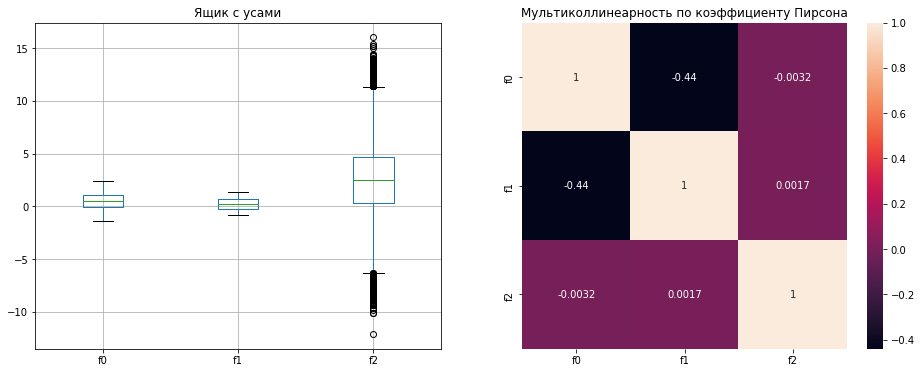

In [6]:
info(df_0)

In [7]:
def cor(df, title):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    plt.scatter(x=df['f0'], y=df['f1'], s=3, alpha=0.1, c='g')
    plt.ylabel('f0')
    plt.xlabel('f1')
    plt.subplot(1, 3, 2)
    plt.scatter(x=df['f0'], y=df['f2'], s=3, alpha=0.1, c='g')
    plt.ylabel('f0')
    plt.xlabel('f2')
    plt.title(title)
    plt.subplot(1, 3, 3)
    plt.scatter(x=df['f1'], y=df['f2'], s=3, alpha=0.1, c='g')
    plt.ylabel('f1')
    plt.xlabel('f2');
    return

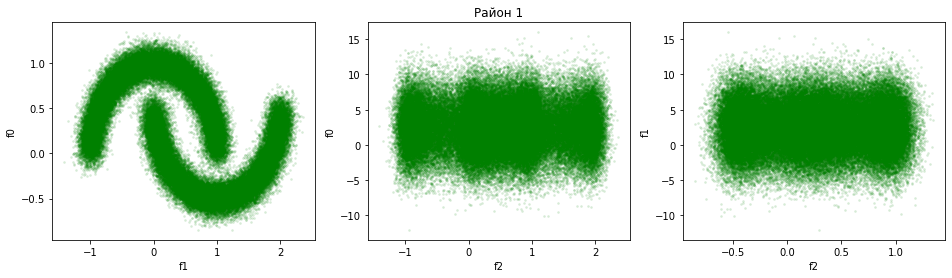

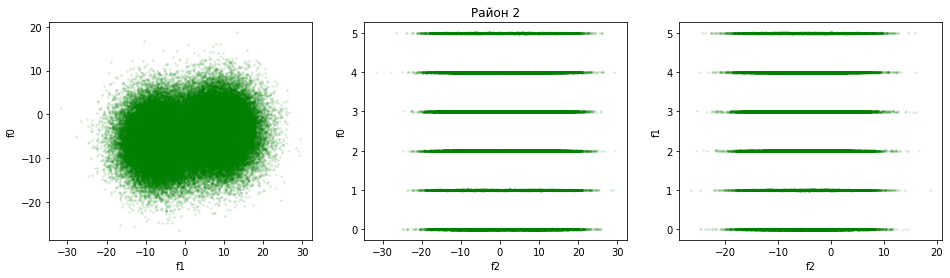

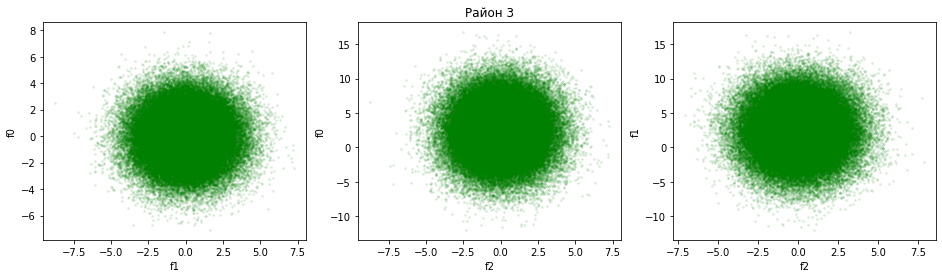

In [8]:
cor(df_0, 'Район 1')
cor(df_1, 'Район 2')
cor(df_2, 'Район 3')

Постороили диаграммы рассеивания для `'fo'` = f(`'f1'`), `'f1'` = f(`'f2'`), `'f0'` = f(`'f2'`). Не обнаружили нелинейных непрерывных зависимостей.

In [9]:
for i, j in zip(['f0', 'f0', 'f1'], ['f1', 'f2', 'f2']):
    print(i, j)

f0 f1
f0 f2
f1 f2


In [10]:
df_0['id'].duplicated().sum()

10

Пропусков нет, но зато имеем 10 повторяющихся скважин. Удалим их

In [11]:
df_0 = df_0.drop_duplicates(subset='id')

Видим, что у `'f2'` имеются выбросы. Необходимо их удалить, так как они будут сильно влиять на прогнозирование. Мультиколлинеарность признаков в датасете первого района не наблюдается.

Проанализируем данные второго района

      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305
--------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
--------------------------------------------------------------
Количество дубликатов в id: 0


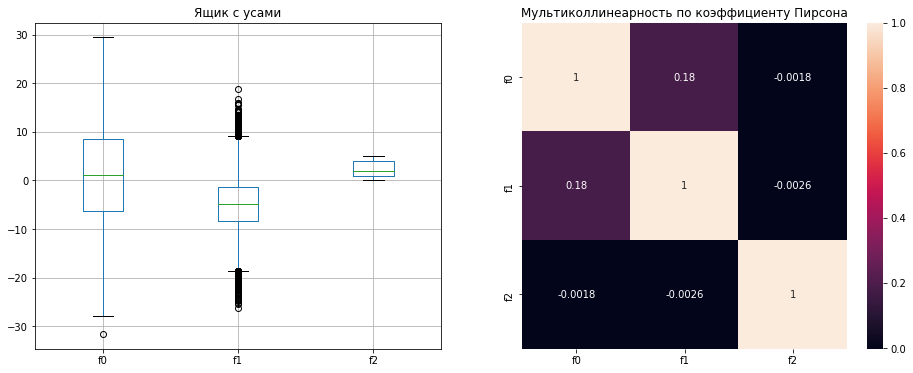

In [12]:
info(df_1)

Дублирующих скважин нет, имеются выбросы в `'f0'`, `'f1'`, мультиколлинеарность не наблюдается.

      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746
--------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
--------------------------------------------------------------
Количество дубликатов в id: 0


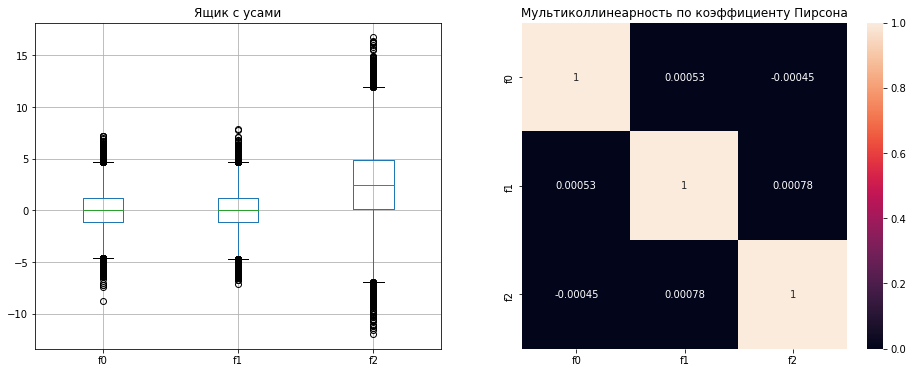

In [13]:
info(df_2)

В третьем районе нет дублирующих скважин, имеются выбросы у всех признаков, мельтиколлинеарность не наблюдается.

Удалим выбросы во всех районах, предварительно сохранив датасеты.

In [14]:
df_0_full = df_0
df_1_full = df_1
df_2_full = df_2

In [15]:
def whiskers_min(df):
    '''Функция определния нижней границы выбросов'''
    df_min = df.quantile(0.25) - 1.5 * (df.quantile(0.75) - df.quantile(0.25))
    return df_min
def whiskers_max(df):
    '''Функция определния верхней границы выбросов'''
    df_max = df.quantile(0.75) + 1.5 * (df.quantile(0.75) - df.quantile(0.25))
    return df_max

def bounder(df):
    '''Функция удаления выбрасов'''
    df = df[(whiskers_min(df["f2"]) < df['f2']) & (whiskers_max(df["f2"]) > df['f2'])]
    df = df[(whiskers_min(df["f1"]) < df['f1']) & (whiskers_max(df["f1"]) > df['f1'])]
    df = df[(whiskers_min(df["f0"]) < df['f0']) & (whiskers_max(df["f0"]) > df['f0'])]
    return df

In [16]:
df_0 = bounder(df_0)
df_1 = bounder(df_1)
df_2 = bounder(df_2)
print('В первом районе удалили', round((100000 - df_0.shape[0]) * 0.01, 2), '% выбросов и дубликатов')
print('Во втором районе удалили', round((100000 - df_1.shape[0]) * 0.01, 2), '% выбросов')
print('В третьем районе удалили', round((100000 - df_2.shape[0]) * 0.01, 2), '% выбросов')

В первом районе удалили 5.16 % выбросов и дубликатов
Во втором районе удалили 6.37 % выбросов
В третьем районе удалили 19.95 % выбросов


В третьем районе наблюдаем очень много удаленных выбросов - почти 20%. Больно, но они вносят много шума

# 2. Обучение и проверка модели для каждого региона

In [17]:
def solver(features, target):
    X_train, X_valid, y_train, y_valid = train_test_split(features, target,
                                                                        test_size=0.25,
                                                                        random_state=12345)
       
    print('Размер тестовой выборки', X_train.shape[0] / features.shape[0])
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    models = LinearRegression()
    models.fit(X_train, y_train)
    predict = models.predict(X_valid)
    return predict, r2_score(y_valid, predict), mean_squared_error(y_valid, predict, squared=False), y_valid

In [18]:
predict_0, r2__df_0, rmse_df_0, y_valid_df_0 = solver(df_0[['f0', 'f1', 'f2']], df_0['product'])
predict_1, r2__df_1, rmse_df_1, y_valid_df_1 = solver(df_1[['f0', 'f1', 'f2']], df_1['product'])
predict_2, r2__df_2, rmse_df_2, y_valid_df_2 = solver(df_2[['f0', 'f1', 'f2']], df_2['product'])

result = pd.DataFrame({'rmse': [rmse_df_0, rmse_df_1, rmse_df_2],
                       'r2_score': [r2__df_0, r2__df_1, r2__df_2],
                       'product': [predict_0.mean(), predict_1.mean(), predict_2.mean()]})

Размер тестовой выборки 0.75
Размер тестовой выборки 0.7499974839729074
Размер тестовой выборки 0.7499923473292179


In [19]:
result

,rmse,r2_score,product
0,37.828145,0.273037,92.490393
1,0.889031,0.999626,68.571559
2,40.223430,0.198711,94.666160


Запас предсказанного сырья в третьем районе самый высокий. Однако квадрат средней квадратичной ошибки также выше. То есть, объем нефти в данном районе колеблится от 54.44 до 134.88 тысяч барелей. В первом - от 54.66 до 130.32 тысяч барелей. Во втором - от 67.69 до 69.45 тысяч барелей. Так как RMSE во втором регионе меньше, это означает, что разброс значений меньше. Коэффициент детерминации R2 у второго региона почти равен единице - это соответствует идеальной модели, когда все точки наблюдений лежат точно на линии регрессии. У остальных регионов R2 достаточно низкий, то есть наблюдается низкая значимость признаков и целевой пременной в рамках модели линейной регрессии.

Обучем подель на данных с выбросами

In [20]:
predict_0_full, r2__df_0_full, rmse_df_0_full, y_valid_df_0_full = solver(df_0_full[['f0', 'f1', 'f2']], df_0_full['product'])
predict_1_full, r2__df_1_full, rmse_df_1_full, y_valid_df_1_full = solver(df_1_full[['f0', 'f1', 'f2']], df_1_full['product'])
predict_2_full, r2__df_2_full, rmse_df_2_full, y_valid_df_2_full = solver(df_2_full[['f0', 'f1', 'f2']], df_2_full['product'])

result_full = pd.DataFrame({'rmse': [rmse_df_0_full, rmse_df_1_full, rmse_df_2_full],
                       'r2_score': [r2__df_0_full, r2__df_1_full, r2__df_2_full],
                       'product': [predict_0_full.mean(), predict_1_full.mean(), predict_2_full.mean()]})

Размер тестовой выборки 0.74999499949995
Размер тестовой выборки 0.75
Размер тестовой выборки 0.75


In [21]:
result_full

,rmse,r2_score,product
0,37.853527,0.272392,92.789156
1,0.893099,0.999623,68.728547
2,40.029709,0.205248,94.965046


Значения объема предсказанных объемов и метрики не сильно изменились. Значит, чистка не повлияла на результат. Будем использовать данные без выбросов.

# 3. Подготовка к расчёту прибыли

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Бюджет на разработку скважин в регионе — 10 млрд рублей. Доход с каждой единицы продукта составляет 450 тыс. рублей. Для разработки выбираются 200 лучших скважин.

Бюджет на разработку = Доход с каждой единицы продукта * количество скважин * объём сырья

In [22]:
#Затраты
EXPENSES = 10000000000
#Доход
INCOME = 450000
#Количество скважин
N = 200

In [23]:
val = EXPENSES / (INCOME * N)
val

111.11111111111111

In [24]:
val * N

22222.222222222223

Из каждой скважины необходимо добывать в среднем не менеее 111.11 тыс. баррелей для того, чтобы скважина была безубыточной (или 22222.22 тыс. баррелей для всех 200 скважин).

Сравним полученный объём сырья со средним запасом в каждом регионе

In [25]:
result['min_required'] = val
result['deficit'] = result['product'] - result['min_required']
round(result[['product', 'min_required', 'deficit']], 2)

,product,min_required,deficit
0,92.49,111.11,-18.62
1,68.57,111.11,-42.54
2,94.67,111.11,-16.44


Если давать оценку по среднему прогнозируемому объему добычи, все районы убыточные. То есть нельзя случайным образом брать скважины - только обеспечивающие наибольший объем добычи.

# 4. Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

Выберем скважины с максимальными значениями предсказаний, просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям. Рассчитаем прибыль для полученного объёма сырья.

In [26]:
def top_200(predict, y_valid):
    #Выберем 200 скважин с максимальными значениями предсказаний
    top_200 = pd.DataFrame({'predict': predict,
                          'target': y_valid}).sort_values(by='predict', ascending=False).iloc[:200]
    #Просуммирем целевое значение объёма сырья, соответствующее этим предсказаниям
    sum_target = top_200['target'].sum()
    #Рассчитаем прибыль для полученного объёма сырья
    profit = sum_target * INCOME - EXPENSES
    return profit

In [27]:
profit_0 = top_200(predict_0, y_valid_df_0)
profit_1 = top_200(predict_1, y_valid_df_1)
profit_2 = top_200(predict_2, y_valid_df_2)
print('Прибыль для полученного объёма сырья 200 лучших скважин 1го региона:', (profit_0 / 1000000000).round(2), 'млрд. рублей')
print('Прибыль для полученного объёма сырья 200 лучших скважин 2го региона:', (profit_1 / 1000000000).round(2), 'млрд. рублей')
print('Прибыль для полученного объёма сырья 200 лучших скважин 3го региона:', (profit_2 / 1000000000).round(2), 'млрд. рублей')

Прибыль для полученного объёма сырья 200 лучших скважин 1го региона: 3.13 млрд. рублей
Прибыль для полученного объёма сырья 200 лучших скважин 2го региона: 2.42 млрд. рублей
Прибыль для полученного объёма сырья 200 лучших скважин 3го региона: 2.54 млрд. рублей


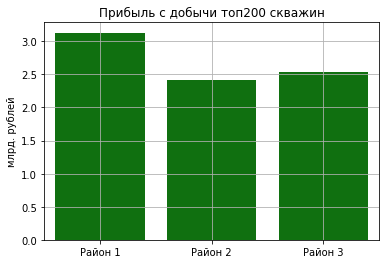

In [28]:
g = pd.Series([(profit_0 / 1000000000).round(2), (profit_1 / 1000000000).round(2), (profit_2 / 1000000000).round(2)])
sns.barplot(y=g, x=['Район 1', 'Район 2', 'Район 3'], color='g')
plt.grid()
plt.ylabel('млрд. рублей')
plt.title('Прибыль с добычи топ200 скважин');

# 5. Риски и прибыль для каждого региона

Применим технику Bootstrap с 1000 выборок по 500 скважин, чтобы найти распределение прибыли. Найдем среднюю прибыль для топ200 скважин, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль

In [29]:
state = RandomState(12345)
def interval(predict, y_valid, sample_size=500, count=200):
    values = []
    q = pd.DataFrame({'predict': predict,
                          'target': y_valid})
    for i in range(1000):
        #сэмплируем 1000 выборок по 500 скважин, сохранняя топ 200
        top = q['predict'].sample(n=sample_size, replace=True, random_state=state).sort_values(ascending=False)
        r = q.loc[top.index, 'target'].iloc[:count]
        #определяем прибыль
        profit_top = r.sum() * INCOME
        values.append(profit_top)

    values = pd.Series(values)
    values = values - EXPENSES
    count = 0
    for k in list(values):
        if k < 0:
             count += 1
    
    #средняя прыбыль всего сэмплирования
    profit_mean = values.mean()
    print('Cредняя чистая прибыль:', round(profit_mean/1000000, 2), 'млн. руб.')
    #нижняя граница доверительного интервала
    lower = values.quantile(0.025)
    #нижняя граница доверительного интервала
    upper = values.quantile(0.975)
    print(f'Границы 95%го доверительного интервала: ({round(lower/1000000, 2)}, {round(upper/1000000, 2)}) в млн. руб')
    #риск убыта
    lesion = count / len(values)
    print('Вероятность убытков:', round(lesion*100, 2), '%')
    
    values.hist(density=True, bins=30)
    plt.axvline(x=lower, c='r')
    plt.axvline(x=upper, c='r')
    plt.ylabel('Средняя прибыль')
    plt.title('Распределение прибыли')
    return

In [30]:
example_df = pd.DataFrame({
    'predict': predict_0,
    'real': y_valid_df_0.tolist()
})

example_df.sample(n=500, replace=True, random_state=state).sort_values(ascending=False, by='predict').head(200).sum()['real']

21973.594158805543

Регион 1
Cредняя чистая прибыль: 350.37 млн. руб.
Границы 95%го доверительного интервала: (-130.25, 844.27) в млн. руб
Вероятность убытков: 8.6 %


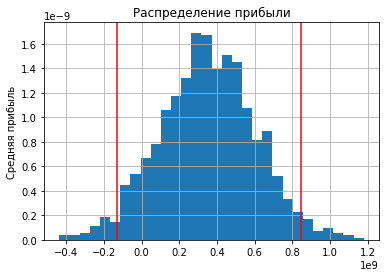

In [31]:
print('Регион 1')
interval(predict_0, y_valid_df_0)

Регион 2
Cредняя чистая прибыль: 434.13 млн. руб.
Границы 95%го доверительного интервала: (33.92, 827.36) в млн. руб
Вероятность убытков: 1.8 %


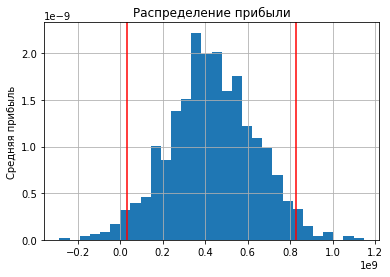

In [32]:
print('Регион 2')
interval(predict_1, y_valid_df_1)

Регион 3
Cредняя чистая прибыль: 362.61 млн. руб.
Границы 95%го доверительного интервала: (-156.66, 944.42) в млн. руб
Вероятность убытков: 9.7 %


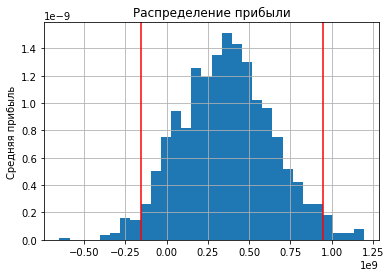

In [33]:
print('Регион 3')
interval(predict_2, y_valid_df_2)

По нижней границе доверительного интервала видно, что в первом и третьем регионе есть убыточные скважины, повышающие общую вероятность убытка.

# Вывод

Единственный район, топ200 скважин которого обеспечивают наименьшую вероятность убыточной добычи нефти - второй (1.8%). Он же единственный, уложившийся в заданную границу в 2.5%. Средняя чистая прибыль у данного района около 433.92 млн. руб. Ни одна из 200 скважин в 95% не даст убытков.